# Positions of Objects on Sky Map

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import spiceypy as sp
from astropy.time import Time
from matplotlib import pyplot as plt

plt.style.use('dark_background')
PI = np.pi

def wrap_0_2pi_pi_pi(x):
    # [0, 360) to [-180, +180)
    return (x + PI) % (2*PI) - PI

def wrap_pi_pi_0_2pi(x):
    # [-180, +180) to [0, 360)
    return (x + 2*PI) - 2*PI*((x + 2*PI)//(2*PI))

def get_pos_lon_lat(naifid, et, ref, abcorr="LT+S", obs=399):
    # Use LT+S light time correction.
    # spkezp returns the directional vector and light time.
    vec, _lt = sp.spkezp(targ=naifid, et=et, ref=ref, abcorr=abcorr, obs=obs)
    _r, lon, lat = sp.recrad(vec)  # lon in [0, 2pi], lat in [-pi/2, +pi/2]
    return vec, lon, lat


NAIF_ID = {'SUN': 10, 'VENUS': 299, 'MOON': 301, 'MARS': 4}
# Mars has the ID 499, however the loaded kernels do not contain the
# positional information. We use the Mars barycentre instead

# Load the SPICE kernels via a meta file
sp.furnsh('kernel_meta.txt')

NOW_UTC = Time.now()
NOW_ET = sp.utc2et(NOW_UTC.iso)

print(f"Used UTC = {NOW_UTC} (in SPICE ET = {NOW_ET})")

Used UTC = 2023-11-22 10:21:10.303225 (in SPICE ET = 753920539.4858733)


## Ecliptic Coordinate System

[``spkezp``](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/spkezp_c.html)
: Return the position of a target body relative to an observing body, optionally corrected for light time (planetary aberration) and stellar aberration.

[``recrad``](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/recrad_c.html)
: Convert rectangular coordinates to r, lon (∈ [0, 2π]), lat (∈ [-π, +π]).

List of frames: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/frames.html#Selecting%20a%20Name

In [2]:
# First, compute the directional vector Earth - body in ECLIPJ2000.
lonlat_ec = dict()

for name, naifid in NAIF_ID.items():
    _vec, lon, lat = get_pos_lon_lat(naifid, NOW_ET, ref='ECLIPJ2000', abcorr="LT+S", obs=399)
    lonlat_ec[name] = [lon, lat]

lonlat_ec

{'SUN': [4.180291175560103, 4.9740504997790175e-05],
 'VENUS': [3.4094137755154503, 0.033178023170225016],
 'MOON': [6.205654333564701, -0.04350452553008132],
 'MARS': [4.15825171611201, -0.0026945552126326705]}

In astronomy, it is customary that longitude increases towards left, not right. Thus, we have to
1. Wrap the [0, 2π] value of longitude to [-π, +π]
2. Put ``-`` sign
3. Change the ticklabels in the plt

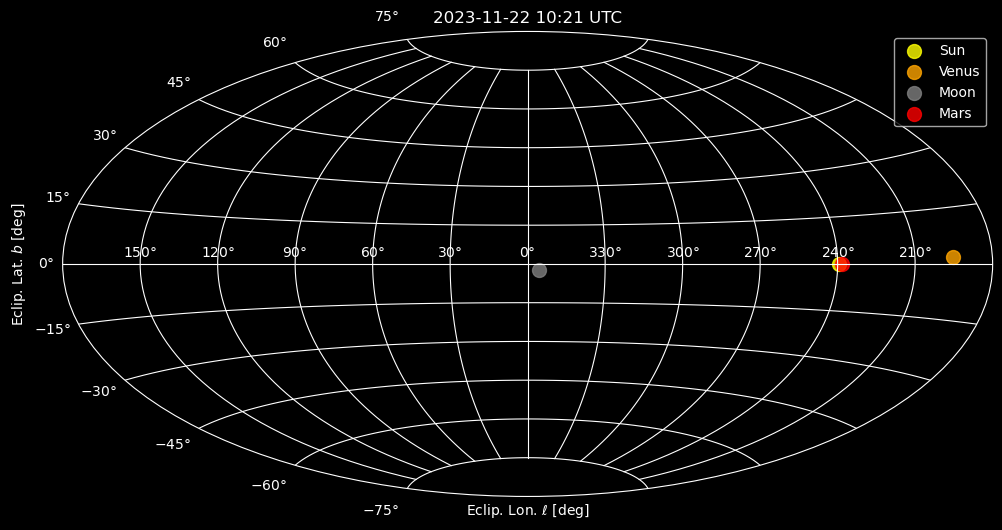

In [46]:
colors = dict(SUN='yellow', VENUS='orange', MOON='gray', MARS='red')

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(projection="aitoff")

for name, color in colors.items():
    ax.scatter(-wrap_0_2pi_pi_pi(lonlat_ec[name][0]), lonlat_ec[name][1],
               color=color, label=name.capitalize(), s=100, alpha=0.8)

def fmt_func(x_rad, pos):
    x_rad = 0 if np.abs(x_rad) <1.e-5 else -x_rad
    x_rad = wrap_pi_pi_0_2pi(x_rad)
    return f'${np.rad2deg(x_rad):.0f}$°'

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt_func))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'${np.rad2deg(x):.0f}$°'))


ax.set(
    title=f'{NOW_UTC.strftime("%Y-%m-%d %H:%M")} UTC',
    xlabel='Eclip. Lon. $\ell$ [deg]',
    ylabel='Eclip. Lat. $b$ [deg]',
)

ax.legend()
ax.grid(True)
plt.savefig("eclipj2000_sky_map.png", dpi=300, bbox_inches='tight')

## Equatorial Coordinate System

In [4]:
# First, compute the directional vector Earth - body in ECLIPJ2000.
lonlat_eq = dict()

for name, naifid in NAIF_ID.items():
    _vec, lon, lat = get_pos_lon_lat(naifid, NOW_ET, ref='J2000', abcorr="LT+S", obs=399)
    lonlat_eq[name] = [lon, lat]

lonlat_eq

{'SUN': [4.141889625909503, -0.3498285048424115],
 'VENUS': [3.4010682320295946, -0.07484137314634107],
 'MOON': [6.229329493273063, -0.07074103083189189],
 'MARS': [4.118367489356059, -0.34768544789702127]}

In [34]:
# === add ecliptic plane on the equatorial plot
# 1. rotation matrix from ecliptic to equatorial coordinates
R_EC2EQ = sp.pxform(fromstr='ECLIPJ2000', tostr='J2000', et=NOW_ET)
# 2. ecliptic plane in ecliptic coordinates (XYZ, "rec(tangular)")
_ec_xyz = np.array([sp.sphrec(r=1, colat=PI/2, lon=_lon) for _lon in np.linspace(0, 2*PI, 100)])
# 3. ecliptic plane in equatorial coordinates (XYZ, "rec(tangular)")
ec_xyz_eq = np.ascontiguousarray((R_EC2EQ @ _ec_xyz.T).T)
# 4. ecliptic plane in equatorial coordinates (r, lon, lat as "rad(spherical)")
ec_eq = np.array([sp.recrad(_xyz) for _xyz in ec_xyz_eq])

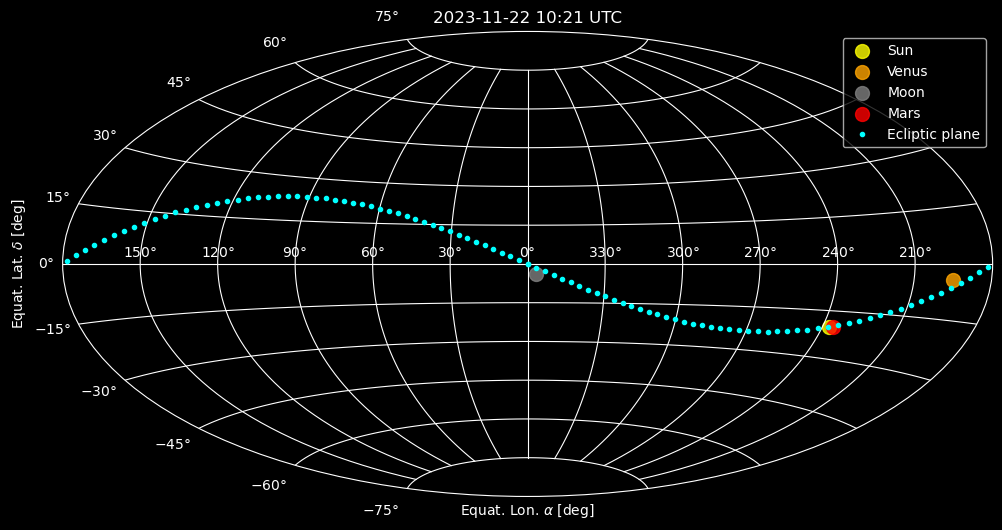

In [45]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(projection="aitoff")

for name, color in colors.items():
    ax.scatter(-wrap_0_2pi_pi_pi(lonlat_eq[name][0]), lonlat_eq[name][1],
               color=color, label=name.capitalize(), s=100, alpha=0.8)

ax.plot(-wrap_0_2pi_pi_pi(ec_eq[:, 1]), ec_eq[:, 2], ".", color='cyan', label='Ecliptic plane')

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt_func))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'${np.rad2deg(x):.0f}$°'))

ax.set(
    title=f'{NOW_UTC.strftime("%Y-%m-%d %H:%M")} UTC',
    xlabel='Equat. Lon. $α$ [deg]',
    ylabel='Equat. Lat. $δ$ [deg]',
)

ax.legend()
ax.grid(True)
plt.savefig("j2000_sky_map.png", dpi=300, bbox_inches='tight')

In [8]:
# Before we plot the data, let's add the Ecliptic plane for the visualisation.
# In ECLIPJ2000 the Ecliptic plane is the equator line (see corresponding
# figure. The latitude is 0 degrees.

# First, we create a separate dataframe for the ecliptic plane
eclip_plane_df = pd.DataFrame()

# Add the ecliptic longitude and latitude values for the plane. Note: here,
# we need to use pi/2 (90 degrees) as the latitude, since we will apply a
# SPICE function that expects spherical coordinates
eclip_plane_df.loc[:, 'ECLIPJ2000_long_rad'] = np.linspace(0, 2*np.pi, 100)
eclip_plane_df.loc[:, 'ECLIPJ2000_lat_rad'] = np.pi/2.0

# Compute the directional vectors of the ecliptic plane for the different
# longitude values (the latitude is constant). Apply the SPICE function sphrec
# to transform the spherical coordinates to vectors. r=1 is the distance,
# here in our case: normalised distance
eclip_plane_df.loc[:, 'ECLIPJ2000_direction'] = \
    eclip_plane_df\
        .apply(lambda x: sp.sphrec(r=1, \
                                         colat=x['ECLIPJ2000_lat_rad'], \
                                         lon=x['ECLIPJ2000_long_rad']), \
               axis=1)

In [9]:
# Compute a transformation matrix between ECLIPJ2000 and J2000 for a fixed
# date-time. Since both coordinate system are inertial (not changing in time)
# the resulting matrix is the same for different ETs
ECL2EQU_MAT = sp.pxform(fromstr='ECLIPJ2000', \
                              tostr='J2000', \
                              et=DATETIME_ET)

# Compute the direction vectors of the Ecliptic plane in J2000 using the
# transformation matrix
eclip_plane_df.loc[:, 'j2000_direction'] = \
    eclip_plane_df['ECLIPJ2000_direction'].apply(lambda x: ECL2EQU_MAT.dot(x))

# Compute now the longitude (and matplotlib compatible version) and the
# latitude values using the SPICE function recrad
eclip_plane_df.loc[:, 'j2000_long_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: sp.recrad(x)[1])

eclip_plane_df.loc[:, 'j2000_long_rad4plot'] = \
    eclip_plane_df['j2000_long_rad'] \
        .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
               else -1*x)

eclip_plane_df.loc[:, 'j2000_lat_rad'] = \
    eclip_plane_df['j2000_direction'].apply(lambda x: sp.recrad(x)[2])

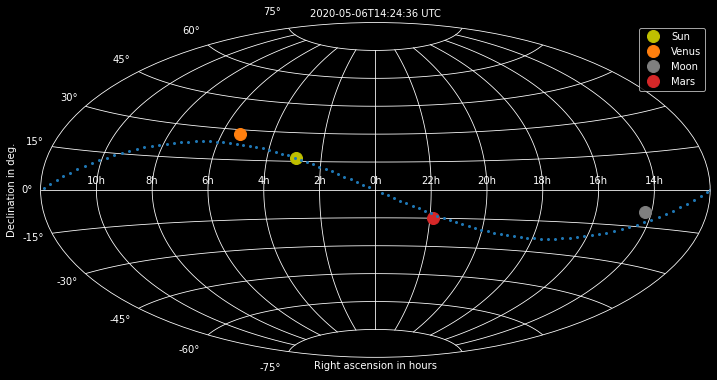

In [10]:
# We plot now the data in equatorial J2000. Again with a dark background and
# the same properties as before
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")
plt.title(f'{DATETIME_UTC} UTC', fontsize=10)

# Iterate through the celestial bodies and plot them
for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):

    plt.plot(solsys_df[f'{body_name}_long_rad4plot_equ'], \
             solsys_df[f'{body_name}_lat_rad_equ'], \
             color=body_color, marker='o', linestyle='None', markersize=12, \
             label=body_name.capitalize())

# Plot the Ecliptic plane as a blue dotted line
plt.plot(eclip_plane_df['j2000_long_rad4plot'], \
         eclip_plane_df['j2000_lat_rad'], color='tab:blue', linestyle='None', \
         marker='o', markersize=2)

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['10h', '8h', '6h', '4h', '2h', '0h', \
                   '22h', '20h', '18h', '16h', '14h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Create a legend and grid
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('j2000_sky_map.png', dpi=300)